# Development

In [28]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Playground

In [56]:
# create, save and load a spinbath
num_baths, num_init_states, all_init_states = 1, 100, True
directory = os.getcwd()
filename = os.path.join( "baths", "test")
kwargs = dict(
    density = 5e-3 / 1e-18, # spins/nm^2 # 1e-3 - 50e-3
    shape = 'circle',
    rmin = 0, 
    rmax = 18e-9,
    bath_kwargs = dict(Bz=500e-4, depth=10e-9),
)

spin_bath = SpinBath('e', **kwargs)
spin_configs, metadata = spin_bath.calc_spin_baths(num_baths, num_init_states, all_init_states=all_init_states)

print("Number of bath spins: ", spin_bath.num_spins)
bath_polarization = calc_bath_polarization(bath_configs)
print("Bath Polarization: ", bath_polarization)

save_spin_baths(spin_configs, metadata, directory, filename)
bath_configs = load_spin_baths(filename, directory)
# fig, ax = visualize_spin_bath(filename, directory, save=False)

Number of bath spins:  5
Bath Polarization:  0.0


NV N
[[-2160000.        0.        0.]
 [       0. -2160000.        0.]
 [       0.        0. -1760000.]]
NV C13
[[ 328904.01712341      -0.          107321.11252956]
 [     -0.         -175861.09849115      -0.        ]
 [ 107321.11252956      -0.         -153042.91863226]]
N C13
[[-39.68554806   0.           6.8245712 ]
 [  0.          20.23143489  -0.        ]
 [  6.8245712   -0.          19.45411317]]


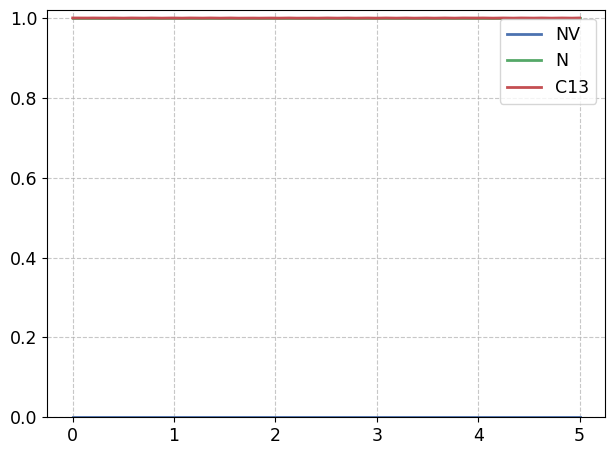

In [4]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
N_pos = (0, 0, np.sqrt(3)*CONST['a_C']/4)
C13_pos /= np.cbrt(np.pi*2) # 
register_config = [('NV', (0, 0, 0), 1, dict(N_zz=0, Bz=0.5)), ('N', N_pos, 0, dict(Bz=0.5)), ('C13', C13_pos, 0, dict(Bz=0.5))]

kwargs = dict(suter_method=False, verbose=False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [("free_evo", dict(t=0.e-6))]

t_list = np.linspace(0, 5e-6, 200)
states = env.calc_states(t_list=t_list)[0, :]
NV_states = [q.ptrace(state, [0]) for state in states]
N_states = [q.ptrace(state, [1]) for state in states]
C13_states = [q.ptrace(state, [2]) for state in states]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in NV_states], label='NV')
ax.plot(t_list*1e6, [state[0,0].real for state in N_states], label='N')
ax.plot(t_list*1e6, [state[0,0].real for state in C13_states], label='C13')
ax.set_ylim(0,1.02)
ax.legend()
plt.show()

(3000000.0, 4000000.0)

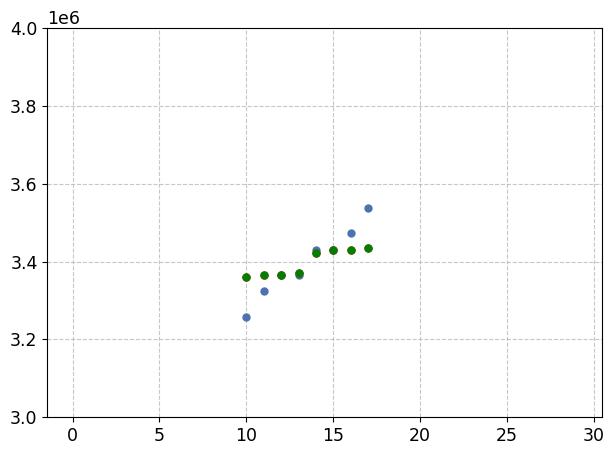

In [65]:
from itertools import combinations
eigv = env.matrices[0].eigenenergies()
diag = env.matrices[0].diag()

transition_freqs1 = []
for eigv_i, eigv_j in combinations(eigv, r=2 ):
    transition_freqs1.append(abs(eigv_i-eigv_j))
transition_freqs1 = np.sort(transition_freqs1)

transition_freqs2 = []
for eigv_i, eigv_j in combinations(diag, r=2 ):
    transition_freqs2.append(abs(eigv_i-eigv_j))
transition_freqs2 = np.sort(transition_freqs2)

transition_freqs3 = []
for eigv_i, eigv_j in combinations(diag2, r=2 ):
    transition_freqs3.append(abs(eigv_i-eigv_j))
transition_freqs3 = np.sort(transition_freqs2)

fig, ax = plt.subplots()
# for transition_freq in transition_freqs:
#     ax.plot(np.linspace(0,1,100), [transition_freq]*100)
ax.plot(transition_freqs1[:30], '.', markersize=10)
ax.plot(transition_freqs2[:30], '.', markersize=10, color='r')
ax.plot(transition_freqs3[:30], '.', markersize=10, color='g')
ax.set_ylim(3e6, 4e6)

In [61]:
from itertools import product
g_e, g_N, g_C = CONST['gamma_e'], CONST['gamma_N'], CONST['gamma_C']
Bz = CONST['Bz']

diag2 = []
for m_e, m_N, m_C in product([0,-1], [-1, 0, 1], [-0.5, 0.5]):
    value = - Bz/(2*np.pi) * (m_e*g_e + m_N*g_N + m_C*g_C)
    if m_e == -1:
        value += CONST['D_gs']
    diag2.append( value )
diag2

[124788.03823278514,
 -33719.96176746604,
 79254.0000001256,
 -79254.0000001256,
 33719.96176746604,
 -124788.03823278514,
 2465280787.944587,
 2465122279.944587,
 2465235253.906355,
 2465076745.9063544,
 2465189719.868122,
 2465031211.8681216]

In [66]:
Bz/(2*np.pi) * 0.5*g_C

79254.0000001256

In [67]:
Bz/(2*np.pi) * g_N

45534.03823265955

In [15]:
env.matrices[0].diag() - env.matrices[0].eigenenergies()

array([ 1.34974074e+01,  6.93421382e+04,  4.96703754e+06,  5.03634683e+06,
       -5.03256704e+06, -5.03255920e+06,  3.47993385e+06,  3.37791472e+06,
        3.41462320e+06,  3.31263922e+06, -6.74537620e+06, -6.84734853e+06])

## Equations svg

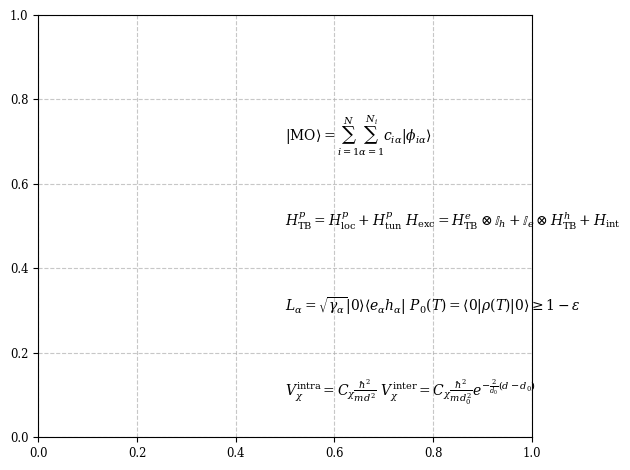

In [84]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.size'] = 10

# plt.text(0.5, 0.5, r'$\pi \frac{\pi}{2} \theta \phi \alpha \omega |\Psi_N\rangle |0\rangle ^{13}C ^{14}N e |\Psi_e\rangle |\Psi_C\rangle $')
# plt.text(0.5, 0.5, r'$ R_y(2\gamma_1) R_y(2\gamma_2) U(\mathbf{\varphi}) U(\mathbf{\delta})  B_z \| [111] \sigma=0.001-0.05\,\text{spins/nm}^2 \tau$')
# plt.text(0.5, 0.5, r'$|0_e\rangle |0_N\rangle |0_C\rangle$')
# plt.text(0.5, 0.5, r'$(-\nu+\frac{\pi}{2})_y (\mu-\frac{\pi}{2})_y \frac{\pi}{2}_x \frac{\pi}{2}_y 2\pi_x $')
# t= np.linspace(0,4*np.pi, 600)
# fig, ax = plt.subplots(figsize=(6,2))
# ax.plot(t, np.sin(2*t))
plt.text(0.5, 0.7, r"$|\text{MO}\rangle = \sum_{i=1}^N \sum_{\alpha=1}^{N_i} c_{i \alpha} |\phi_{i \alpha}\rangle$")
plt.text(0.5, 0.5, r"$H^p_{\text{TB}} = H_{\text{loc}}^p + H_{\text{tun}}^p$ $H_{\text{exc}} = H_{\text{TB}}^e\otimes \mathbb{I}_h + \mathbb{I}_e\otimes H_{\text{TB}}^h + H_{\text{int}}$")
plt.text(0.5,0.3,r"$L_{\alpha}=\sqrt{\gamma_{\alpha}}|0\rangle\langle e_{\alpha}h_{\alpha}|$ $P_0(T) = \langle 0| \rho(T)|0\rangle \geq 1 - \epsilon$")
plt.text(0.5, 0.1, r"$V_\chi^{\text{intra}} = C_\chi \frac{\hbar^2}{m d^2}$ $V_\chi^{\text{inter}} = C_\chi \frac{\hbar^2}{m d_0^2} e^{-\frac{2}{d_0} \left(d-d_0\right)}$")
plt.savefig('test.svg', transparent=True)

In [17]:
from qiskit import QuantumCircuit

# Create a quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Apply a CNOT gate controlled by a classical bit
qc.measure(0, 0)  # Measure qubit 0 into classical bit 0
qc.x(1).c_if(0, 1)  # Apply CNOT only if classical bit 0 is 1

# Save the circuit as an SVG file
qc.draw(output="mpl", filename="classical_controlled_cnot.svg")

print("Quantum circuit saved as classical_controlled_cnot.svg")


Quantum circuit saved as classical_controlled_cnot.svg


C:\Users\Dennis Herb\AppData\Local\Temp\ipykernel_7400\1777452806.py:8: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(1).c_if(0, 1)  # Apply CNOT only if classical bit 0 is 1


## Reliablity of the Cluster Expansion

In [ ]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

In [ ]:
%%time

log_negs_list = []
approx_levels = ['no_bath', 'gCCE0']#, 'gCCE1', 'gCCE2', 'full_bath']
for env_approx_level in approx_levels:
    kwargs = dict(dm_offset=1e-4, env_approx_level=env_approx_level, suter_method=True, verbose=False, target=bell_state, thermal_bath=True, bath_configs=bath_configs)
    env = Environment2(register_config, **kwargs)
    
    env.gate_props_list = [
        ("free_evo", dict(t=0.e-6)),
        ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
        ("free_evo", dict(t=4.06620465e-6)),
        ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
        ("free_evo", dict(t=1.57022726e-6)),
        ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
        ("free_evo", dict(t=1.50788214e-6)),
    ]
    
    t_list = np.linspace(env.total_gate_time, 25e-6, 250)
    states = env.calc_states(t_list=t_list)
    log_negs_list.append( [calc_logarithmic_negativity(state) for state in states[0,:]] )

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i, log_negs in enumerate(log_negs_list):
    ax.plot(t_list*1e6, log_negs, label=approx_levels[i])
ax.legend()
ax.set_ylim(0,1.02)
plt.show()

### old code

In [ ]:
# old code version
%%time
kwargs = dict(env_approx_level='gCCE2', instant_pulses=True, suter_method=True, verbose=False, target=bell_state, thermal_bath=False)
env = Environment(register_config, bath_configs[3:4], **kwargs)

t_list = np.linspace(env.total_time, 25e-6, 250)
pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]
log_negs_gCCE2 = env.get_values(pulse_seq, 'log_neg', t_list=t_list)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(t_list*1e6, log_negs_no_bath, label='no bath')
ax.plot(t_list*1e6, log_negs_gCCE0, label='gCCE0')
ax.plot(t_list*1e6, log_negs_gCCE1, label='gCCE1')
ax.plot(t_list*1e6, log_negs_gCCE2, label='gCCE2')
ax.plot(t_list*1e6, log_negs_full_bath, label='exact')
ax.legend()
ax.set_ylim(0,1.02)
plt.show()

## Random Spin Baths

In [4]:
# Fig. 3 in Dominik's paper (binomial distribution)

rmin, rmax = 0, 1.8e-9
volume = 4/3 * np.pi * (rmax**3 - rmin**3)

a_C = CONST['a_C'] # lattice constant for carbon
V_unit = a_C**3 # volume of the unit cell
N_unit = CONST['N_unit'] # number of carbon atoms per unit cell
n = N_unit/V_unit # density of carbon atoms
N =  int(volume * n) # number of carbon atoms

# Binomial distribution: abundancy is probability of finding a C-13 instead of a C-12
abundancies = np.arange(2, 11) * 0.005e-2
more_than_zero, more_than_one, more_than_two = [], [], []
for abundancy in abundancies: 
    zero_C13 = (1-abundancy)**N
    one_C13 = N * abundancy * (1-abundancy)**(N-1)
    two_C13 = N*(N-1)/2 * abundancy**2 * (1-abundancy)**(N-2)
    more_than_zero.append( 1- zero_C13 )
    more_than_one.append( 1- zero_C13 - one_C13 )
    more_than_two.append( 1- zero_C13 - one_C13 - two_C13 )

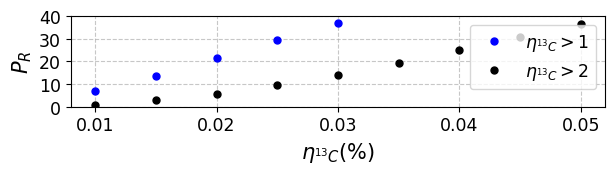

In [5]:
fig, ax = plt.subplots(figsize=(6.4, 4.8//2))

ax.plot(abundancies, more_than_one, 'b.', markersize=10, label=r'$\eta_{^{13}C}>1$')
ax.plot(abundancies, more_than_two, 'k.', markersize=10, label=r'$\eta_{^{13}C}>2$')

# plot settings
ax.set_ylabel(r'$P_R$')
ax.set_xlabel(r'$\eta_{^{13}C} (\%)$')
ax.set_ylim(0, 0.4)
# ax.set_xlim(0.01e-2, 0.05e-2)
ax.legend()
ax.set_xticks([0.01e-2, 0.02e-2, 0.03e-2, 0.04e-2, 0.05e-2], [0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40])

plt.show()

## Optimization

In [ ]:
# Optimize pulse sequence 
from scipy.optimize import basinhopping, Bounds

def print_progress(x, f, accepted):
    print(f"Current parameters: {x}, Infidelity: {f}, Accepted: {accepted}")

register_C13_pos = [(0.87e-9, 0, 0.19e-9)] #, (0.56e-9, 0.77e-9, 0.31e-9), (-0.83e-9, 1.15e-9, 0.46e-9)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 2e-9, 4.2e-9
target_state = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )
init_pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]

spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax)
system_configs = spin_config.system_configs['no_bath']

def calc_infidelity(pulse_seq):
    system = System(system_configs, [])
    pulses = Pulses(system, pulse_seq, target_state)
    return 1 - pulses.final_fidelity

basinhopping(
    calc_infidelity, init_pulse_seq, 
    minimizer_kwargs={"method": "L-BFGS-B", "bounds": Bounds([0]*10, [10e-6]*4+[np.pi]*3+[2*np.pi]*3) },
    callback=print_progress, niter=10,
)